In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from main import plot_predictions

2023-11-18 16:00:42.385461: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#read the data
songdata= pd.read_csv('song_data.csv')
songdata.head()

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
0,Boulevard of Broken Dreams,73,262333,0.005520,0.496,0.682,0.000029,8,0.0589,-4.095,1,0.0294,167.060,4,0.474
1,In The End,66,216933,0.010300,0.542,0.853,0.000000,3,0.1080,-6.407,0,0.0498,105.256,4,0.370
2,Seven Nation Army,76,231733,0.008170,0.737,0.463,0.447000,0,0.2550,-7.828,1,0.0792,123.881,4,0.324
3,By The Way,74,216933,0.026400,0.451,0.970,0.003550,0,0.1020,-4.938,1,0.1070,122.444,4,0.198
4,How You Remind Me,56,223826,0.000954,0.447,0.766,0.000000,10,0.1130,-5.065,1,0.0313,172.011,4,0.574


In [3]:
songdata.shape

(18835, 15)

### Preprocessing

In [4]:
songdata.isnull().sum()

song_name           0
song_popularity     0
song_duration_ms    0
acousticness        0
danceability        0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
audio_mode          0
speechiness         0
tempo               0
time_signature      0
audio_valence       0
dtype: int64

In [5]:
songdata.duplicated().sum()

3909

In [6]:
songdata[(songdata.duplicated())]

,song_name,song_popularity,song_duration_ms,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,audio_mode,speechiness,tempo,time_signature,audio_valence
173,Sex on Fire,81,203346,0.00172,0.542,0.905,0.010400,9,0.1360,-5.653,1,0.0540,153.398,4,0.374
179,Use Somebody,79,230760,0.00552,0.276,0.715,0.000417,0,0.2010,-5.356,1,0.0432,137.028,4,0.173
212,Hips Don't Lie,84,218093,0.28400,0.778,0.824,0.000000,10,0.4050,-5.892,0,0.0712,100.024,4,0.756
414,Hotel California - Remastered,83,391376,0.00574,0.579,0.508,0.000494,2,0.0575,-9.484,1,0.0270,147.125,4,0.609
421,Me and Bobby McGee,69,271333,0.30200,0.453,0.464,0.000060,2,0.1520,-10.960,1,0.0431,93.190,4,0.658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18797,The Time I've Wasted,63,213249,0.79600,0.473,0.250,0.000088,5,0.1010,-11.263,1,0.0304,145.027,4,0.261
18811,Oceans,69,216186,0.27400,0.404,0.480,0.000009,9,0.1320,-8.906,0,0.0303,129.162,3,0.200
18817,Life Is Confusing,64,171413,0.95500,0.373,0.216,0.001050,1,0.0739,-11.410,1,0.0326,129.030,4,0.496
18826,Call It Dreaming,67,231760,0.61000,0.519,0.515,0.000057,5,0.1070,-9.448,1,0.0310,80.329,4,0.714


In [7]:
songdata.drop_duplicates(keep='first',inplace=True)

In [8]:
X= songdata.drop(['song_name','song_popularity'],axis=1)  #axis=1 is by columns
y= songdata['song_popularity']

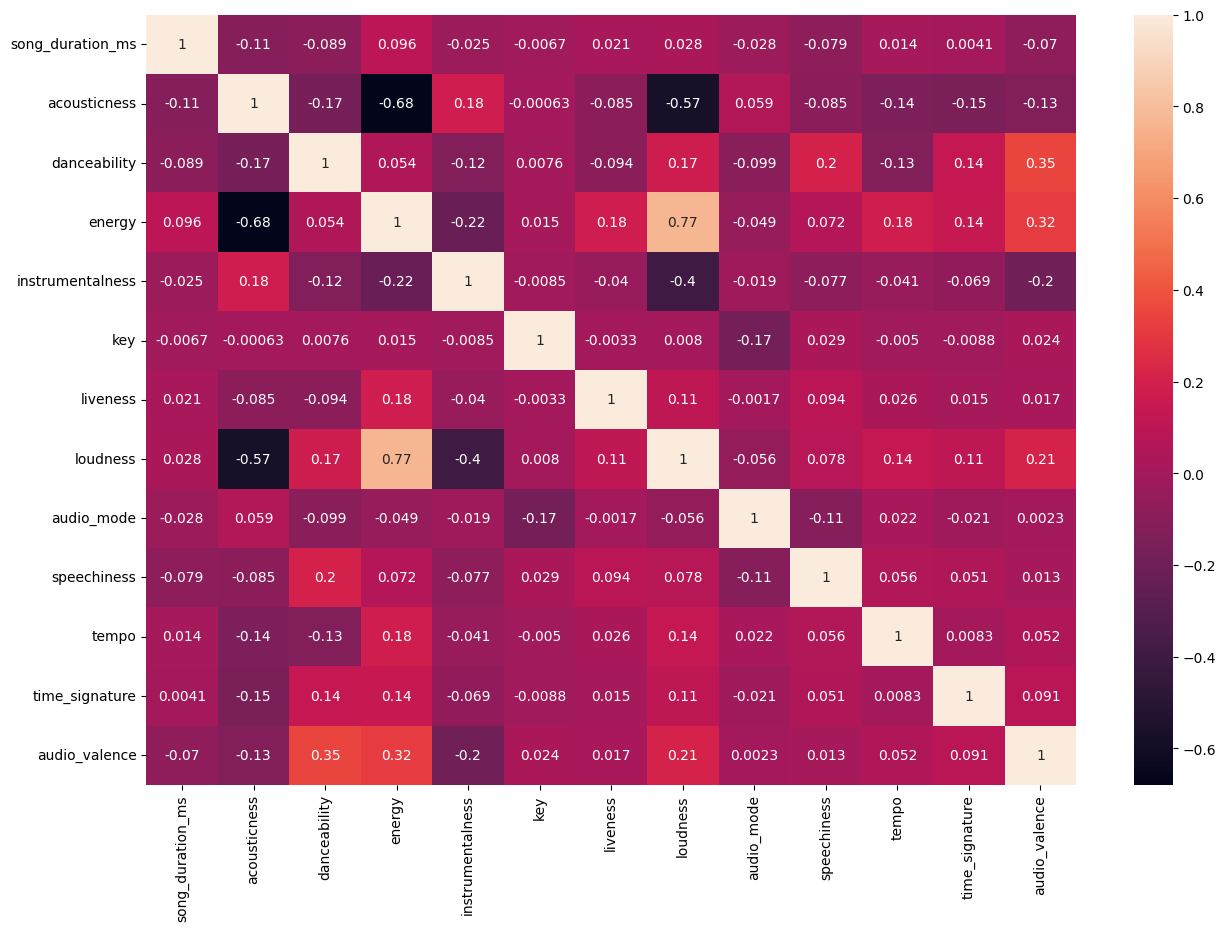

In [9]:
#check colinearity
plt.figure(figsize=(15,10))
sns.heatmap(X.corr(),annot= True,)
plt.show()

In [10]:
#energy and loudness are highly corerelated. Therefore, can drop anyone of them. (here, dropping energy)
X.drop(['energy'],inplace=True,axis=1)

### Train Test Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [12]:
y_train.values.reshape(-1,1)

array([[68],
       [59],
       [33],
       ...,
       [24],
       [ 2],
       [51]])

In [13]:
scaler= MinMaxScaler()
scaler.fit(X_train)
scaled_x_train= scaler.transform(X_train)
scaled_x_test = scaler.transform(X_test)
y_train= scaler.fit_transform(y_train.values.reshape(-1,1))
y_test=scaler.fit_transform(y_test.values.reshape(-1,1))

In [14]:
print(scaled_x_train.shape)
print(scaled_x_test.shape)

(11940, 12)
(2986, 12)


### Creating the Model

In [15]:
model = Sequential()
model.add(Dense(128,activation='relu',input_shape=[12,]))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1664      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 16)                5

### Train the model

In [17]:
early_stop= EarlyStopping(patience=10)

model.fit(scaled_x_train,y_train,validation_data=(scaled_x_test,y_test),epochs=50,callbacks=[early_stop])

Epoch 1/50
374/374 [==============================] - 2s 2ms/step - loss: 0.0759 - val_loss: 0.0481
Epoch 2/50
374/374 [==============================] - 1s 2ms/step - loss: 0.0426 - val_loss: 0.0456
Epoch 3/50
374/374 [==============================] - 1s 2ms/step - loss: 0.0415 - val_loss: 0.0437
Epoch 4/50
374/374 [==============================] - 1s 2ms/step - loss: 0.0414 - val_loss: 0.0430
Epoch 5/50
374/374 [==============================] - 1s 2ms/step - loss: 0.0412 - val_loss: 0.0428
Epoch 6/50
374/374 [==============================] - 1s 2ms/step - loss: 0.0411 - val_loss: 0.0434
Epoch 7/50
374/374 [==============================] - 1s 2ms/step - loss: 0.0409 - val_loss: 0.0439
Epoch 8/50
374/374 [==============================] - 1s 2ms/step - loss: 0.0409 - val_loss: 0.0440
Epoch 9/50
374/374 [==============================] - 1s 2ms/step - loss: 0.0407 - val_loss: 0.0424
Epoch 10/50
374/374 [==============================] - 1s 2ms/step - loss: 0.0407 - val_loss: 0.0425

<Axes: >

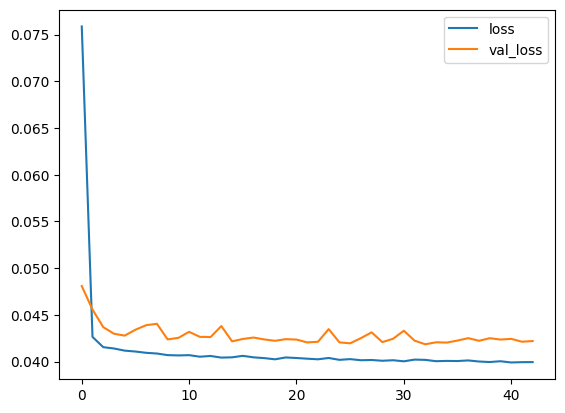

In [18]:
losses= pd.DataFrame(model.history.history)
losses.plot()

94/94 - 0s - loss: 0.0422 - 93ms/epoch - 992us/step
94/94 [==============================] - 0s 810us/step


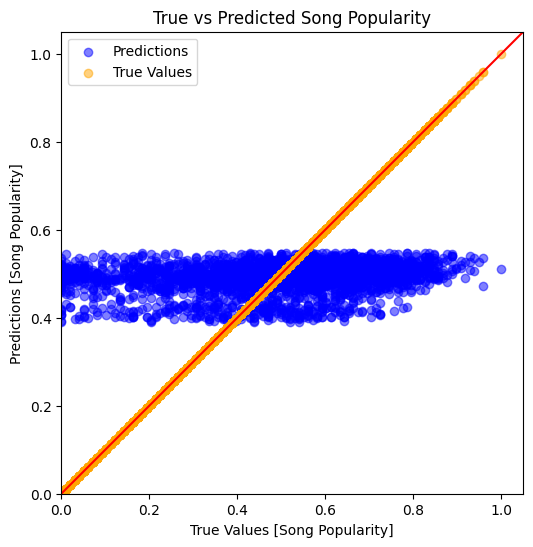

In [19]:
model.evaluate(scaled_x_test,y_test,verbose=2)
plot_predictions(y_test, model.predict(scaled_x_test))